## Introduction

In this notebook we trained a model to classify a portrait into one of two classes: generated by AI or candid. 
We used fastai library to train the model and downloaded data from kaggle.  

## Problem Definition

The fast developments in generative AI bring many benefits, but they also come with notable drawbacks—one of which is the ability to create realistic images of people who do not exist. In this project, we trained a classifier to distinguish between candid portraits and AI-generated images. Being able to accurately classify each photo helps us assess the authenticity of images and increases our confidence in their honesty.

### dependencies

In [7]:
!pip install datasets bing-image-downloader
!{sys.executable} -m pip install fastai

zsh:1: parse error near `-m'


## Dataset Creation and Preparation

In [9]:
from fastai.vision.all import *
from pathlib import Path

In [12]:
from pathlib import Path
from PIL import Image

folders = ['data/real', 'data/ai']

for f in folders:
    folder = Path(f)
    for img_path in folder.glob('*.png'):
        img = Image.open(img_path)
        img.convert('RGB').save(img_path.with_suffix('.jpg'))
        img_path.unlink()

print('done')

done


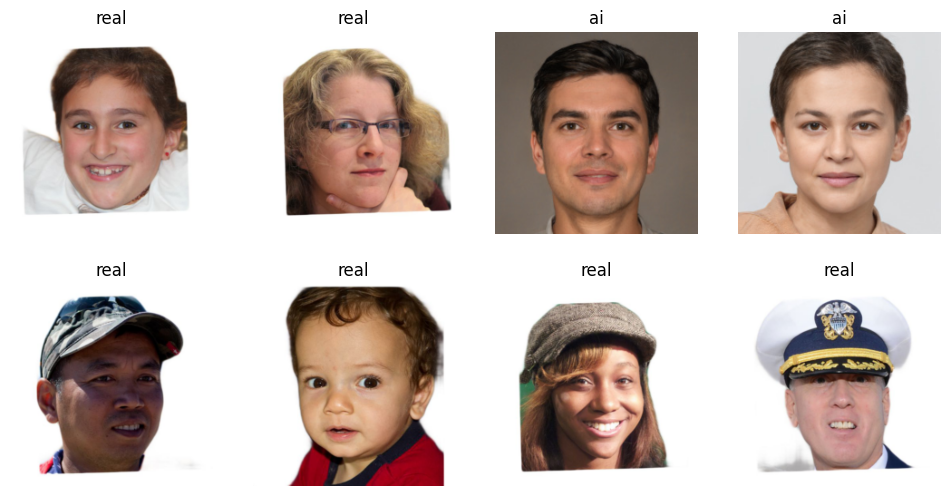

In [14]:
path = Path('data')

dls = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(224)
)

dls.show_batch(max_n=8)

## Model training

In [16]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.488148,1.055482,0.425000,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.435731,0.791307,0.350000,00:02
1,0.326909,0.410372,0.200000,00:02
2,0.221070,0.264180,0.100000,00:02


### Training Curve

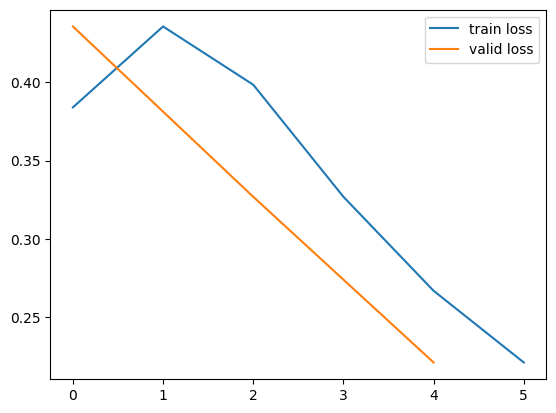

In [19]:
train_losses = [l.item() for l in learn.recorder.losses]
valid_losses = [v[0] for v in learn.recorder.values]

plt.plot(train_losses, label='train loss')
plt.plot(range(0, len(train_losses), len(train_losses)//len(valid_losses)), valid_losses, label='valid loss')
plt.legend()
plt.show()

## Evaluation

### Confusion matrix

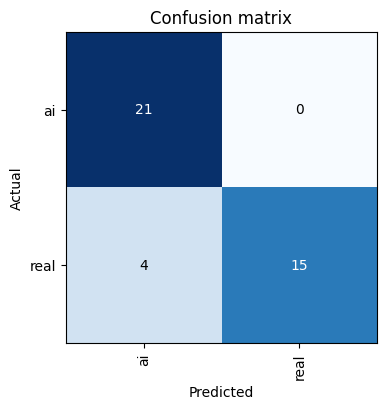

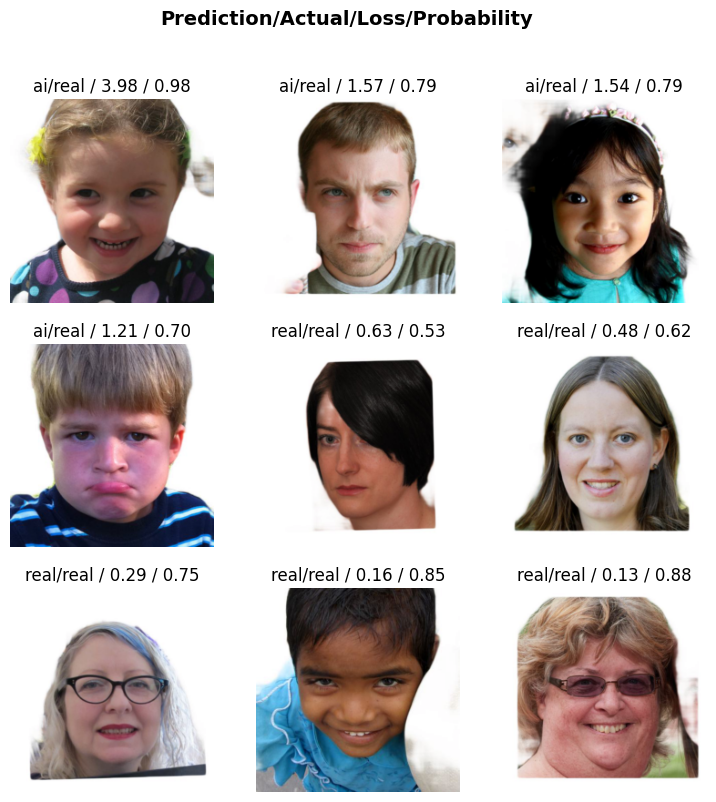

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4))
interp.plot_top_losses(9, nrows=3)

In [27]:
def show_prediction(idx):
    img, label = dls.valid_ds[idx]
    pred, pred_idx, probs = learn.predict(img)
    
    print(f'True label    : {label}')
    print(f'Predicted     : {pred}')
    print(f'Confidence    : {probs[pred_idx]:.2f}')
    show_image(img)

preds, targs = learn.get_preds(dl=dls.valid)
pred_labels = preds.argmax(dim=1)
incorrect_indices = (pred_labels != targs).nonzero().flatten()
correct_indices = (pred_labels == targs).nonzero().flatten()

=== Incorrect predictions ===


True label    : TensorCategory(1)
Predicted     : ai
Confidence    : 0.79
----------------------------------------


True label    : TensorCategory(1)
Predicted     : ai
Confidence    : 0.98
----------------------------------------


True label    : TensorCategory(1)
Predicted     : ai
Confidence    : 0.79
----------------------------------------


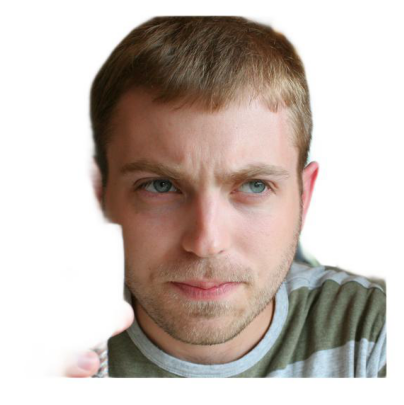

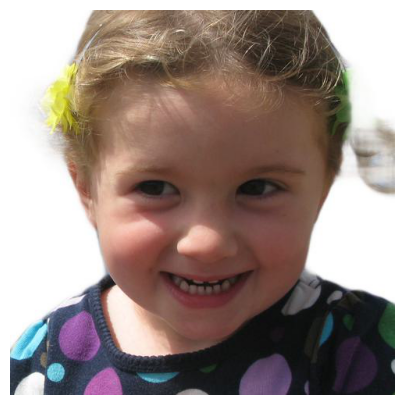

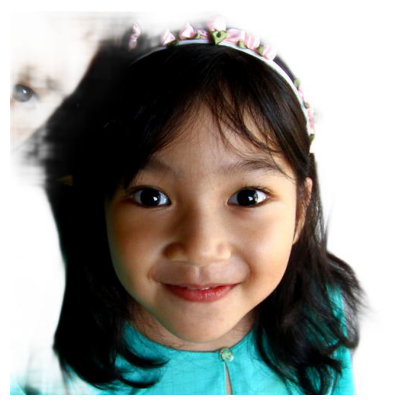

In [29]:
print('=== Incorrect predictions ===')
for i in incorrect_indices[:3]:
    show_prediction(i.item())
    print('-' * 40)

=== Correct predictions ===


True label    : TensorCategory(0)
Predicted     : ai
Confidence    : 1.00
----------------------------------------


True label    : TensorCategory(1)
Predicted     : real
Confidence    : 0.62
----------------------------------------


True label    : TensorCategory(0)
Predicted     : ai
Confidence    : 1.00
----------------------------------------


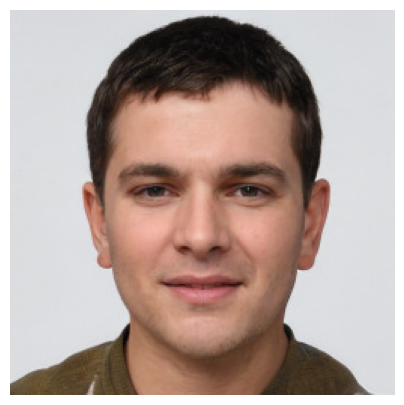

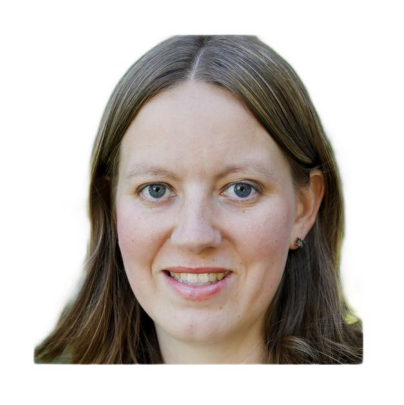

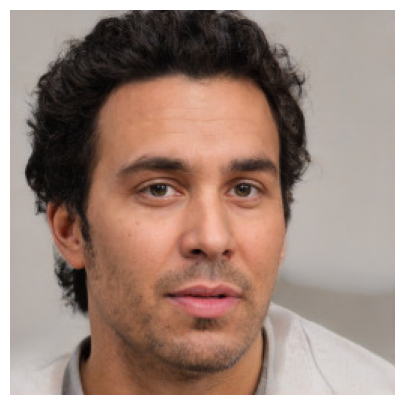

In [31]:
print('=== Correct predictions ===')
for i in correct_indices[:3]:
    show_prediction(i.item())
    print('-' * 40)

## Model Weaknesses

The model’s few errors occur when real images look overly smooth or digitally processed, making them visually similar to AI-generated faces. In these cases, the model is also highly confident in its wrong predictions, indicating a blurred decision boundary between the two classes. Additionally, the model is sensitive to image quality issues such as lighting, blur, or contrast, which can lead to misclassification.